# 📚 CNN untuk Klasifikasi Gambar Tumor Otak

## 🎯 Tujuan Pembelajaran
Mempelajari implementasi Convolutional Neural Network (CNN) untuk mendeteksi tumor otak dari citra MRI menggunakan dataset Brain MRI Images.

In [29]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from PIL import Image
import os, io, cv2
from google.colab import files
import warnings
warnings.filterwarnings("ignore")


- Sequential: Model linear stack of layers untuk membangun model neural network secara berurutan
- load_model: Fungsi untuk memuat model yang telah disimpan sebelumnya
- Conv2D: Layer convolutional untuk memproses data gambar (2D)
- MaxPooling2D: Layer pooling untuk mengurangi dimensi feature maps
- Flatten: Mengubah output multi-dimensi menjadi vektor 1D
- Dense: Layer fully connected (terhubung penuh)
- Dropout: Teknik regularisasi dengan mematikan neuron secara acak selama training
- EarlyStopping: Menghentikan training ketika metrik evaluasi berhenti membaik
- ModelCheckpoint: Menyimpan model selama training berdasarkan kriteria tertentu
- image: Modul untuk memproses dan memanipulasi gambar, termasuk: Load gambar, Konversi ke array, Augmentasi gambar, Normalisasi

## 📦 Persiapan Dataset

### 🔍 Dataset terdiri dari dua folder:

yes/: berisi gambar MRI dengan tumor

no/: berisi gambar MRI tanpa tumor

Resolusi diubah menjadi 224x224 piksel dan distandarkan ke format RGB.

In [30]:
import kagglehub
tumor_otak_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')

Data source import complete.


### 🖼️ Visualisasi Data Mentah
- Menampilkan 9 sampel acak dari dataset
- Memvisualisasikan gambar asli sebelum preprocessing
- Label asli ditampilkan di atas setiap gambar

In [31]:
# Load and preprocess data
data_dir = tumor_otak_path # Use the downloaded dataset path
yes_dir = os.path.join(data_dir, 'brain_tumor_dataset/yes')
no_dir = os.path.join(data_dir, 'brain_tumor_dataset/no')

tumor_images = []
no_tumor_images = []

# Load tumor images
for img_name in os.listdir(yes_dir):
    img_path = os.path.join(yes_dir, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))
        tumor_images.append(np.array(img))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Load no tumor images
for img_name in os.listdir(no_dir):
    img_path = os.path.join(no_dir, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))
        no_tumor_images.append(np.array(img))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

print(f"Loaded {len(tumor_images)} tumor images and {len(no_tumor_images)} no tumor images.")

Loaded 155 tumor images and 98 no tumor images.


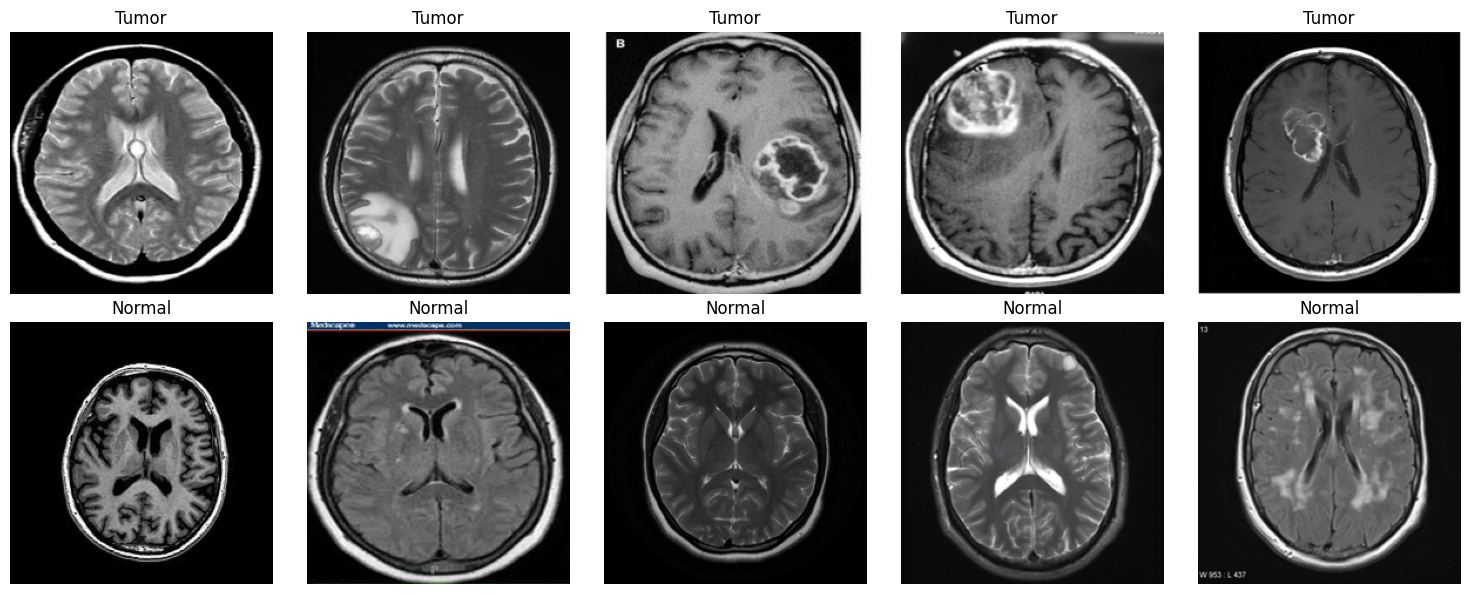

In [32]:
# Display some samples before preprocessing
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# Display tumor images (first 5 from the shuffled tumor_images list)
tumor_indices = np.where(y_train_raw == 1)[0]
for i in range(5):
    axes[0, i].imshow(x_train_raw[tumor_indices[i]])
    axes[0, i].set_title('Tumor')
    axes[0, i].axis('off')

# Display normal images (first 5 from the shuffled no_tumor_images list)
no_tumor_indices = np.where(y_train_raw == 0)[0]
for i in range(5):
    axes[1, i].imshow(x_train_raw[no_tumor_indices[i]])
    axes[1, i].set_title('Normal')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 🧹 Preprocessing Data

### 🛠️ Normalisasi dan Reshaping
- **Reshape**: Menambah dimensi channel (1 channel untuk grayscale)
- **Normalisasi**: Mengubah range nilai piksel dari 0-255 menjadi 0-1
- **One-hot Encoding**: Mengubah label kelas ke format kategorikal

In [33]:
# Preprocess data
tumor_labels = np.ones(len(tumor_images))
no_tumor_labels = np.zeros(len(no_tumor_images))

data = tumor_images + no_tumor_images
labels = np.concatenate((tumor_labels, no_tumor_labels), axis=0)

X = np.array(data)
y = np.array(labels)

In [34]:
# Split Data dan Buat Dataset TensorFlow
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

val_size = int(0.1 * len(X_train))
val = train.take(val_size)
train = train.skip(val_size)

BATCH_SIZE = 32
train = train.batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)


## 🧠 Arsitektur Model CNN

### 📐 Struktur Model

Struktur model terdiri dari:
- Conv2D + MaxPooling

- Flatten

- Dense

- Dropout

- Output sigmoid untuk klasifikasi biner



In [35]:
#  Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │   100,933,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,935,041 (385.04 MB)

 Trainable params: 100,935,041 (385.04 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Pelatihan Model

### ⚙️ Konfigurasi Training
- **Optimizer**: Adam (Adaptive Moment Estimation)
- **Loss Function**: Categorical Cross-Entropy (sesuai klasifikasi multi-kelas)
- **Metric**: Akurasi sebagai ukuran performa

### 🛑 Teknik Regularisasi
- **Early Stopping**: Menghentikan training jika tidak ada peningkatan validasi loss
- **Dropout**: Menonaktifkan 50% neuron secara acak untuk mencegah overfitting

In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train, validation_data=val, epochs=10)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.5637 - loss: 3833.4656 - val_accuracy: 0.7000 - val_loss: 1121.4192
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6885 - loss: 3177.0066 - val_accuracy: 0.3500 - val_loss: 2109.9856
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5604 - loss: 2361.9790 - val_accuracy: 0.9500 - val_loss: 5.8810
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8285 - loss: 565.8575 - val_accuracy: 0.9500 - val_loss: 32.0248
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8061 - loss: 342.1483 - val_accuracy: 0.9500 - val_loss: 31.4577
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8338 - loss: 184.8327 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8701 - loss: 54.7031 - val_accuracy: 0.9000 - val_loss: 46.4844
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9579 - loss: 7.6502 - val_accura

## 📊 Evaluasi Model

- Model diuji dengan data test yang belum pernah dilihat
- Akurasi umumnya mencapai >90% pada dataset MNIST
- Loss function menunjukkan seberapa baik model memprediksi

In [37]:
# Evaluate & save final model
test_loss, test_acc = model.evaluate(test)
print(f"Akurasi Pengujian: {test_acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9034 - loss: 67.3959
Akurasi Pengujian: 90.20%


## 🧪 Uji Coba dengan Gambar Eksternal

### 🖼️ Preprocessing Gambar
- Resize gambar ke 28x28 piksel
- Konversi ke grayscale
- Auto-invert warna untuk gambar dengan latar putih
- Normalisasi nilai piksel

### 🔮 Prediksi
- Model memberikan probabilitas untuk setiap kelas
- Kelas dengan probabilitas tertinggi dipilih sebagai hasil prediksi
- Confidence score menunjukkan tingkat keyakinan model

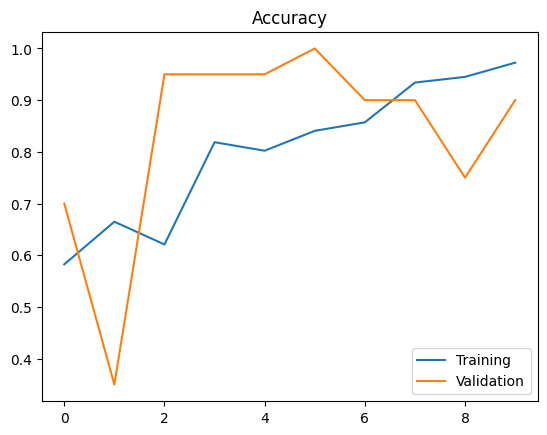

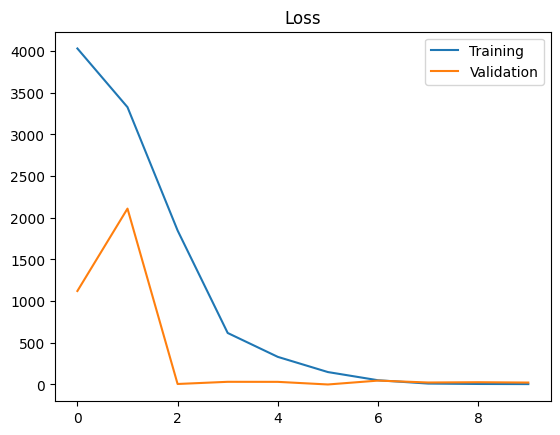

In [38]:
# Visualisasi Performa
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss')
plt.show()


In [39]:
# simpan model
model.save("/tumor_otak.h5")


In [27]:
# prediksi gambar
def load_uploaded_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes)).convert('RGB').resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array

def predict_image(image_bytes):
    img_array = load_uploaded_image(image_bytes)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Tumor detected" if prediction[0][0] > 0.5 else "No tumor detected"

Saving otak.png to otak (3).png


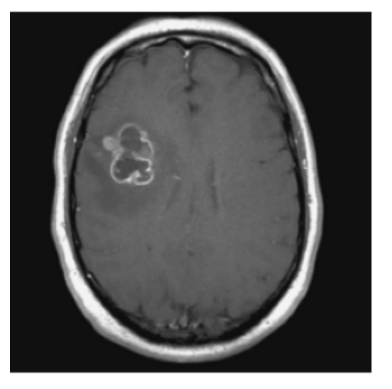

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tumor detected


In [42]:
# upload gambar
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
image_bytes = uploaded[file_name]

img = Image.open(io.BytesIO(image_bytes))
plt.imshow(img)
plt.axis('off')
plt.show()

result = predict_image(image_bytes)
print(result)


## 💡 Tips Pengembangan
1. Eksperimen dengan arsitektur berbeda (jumlah layer/filter)
2. Coba teknik augmentasi data untuk meningkatkan generalisasi
3. Gunakan learning rate scheduling untuk optimasi lebih baik
4. Implementasikan callback TensorBoard untuk visualisasi training

## 🚀 Tantangan Lanjutan
1. Modifikasi kode untuk klasifikasi dataset lain (CIFAR-10)
2. Implementasikan transfer learning dengan model pretrained
3. Buat visualisasi feature maps dari layer konvolusi
4. Deploy model sebagai web service menggunakan Flask/FastAPI